In [1]:
#some of blocks below are not used.
import random
# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

from pathlib import Path
import sys

from glob import glob
from PIL import Image
from collections import defaultdict

import zipfile

In [2]:
#EXTACT ALL FILES FROM ZIP 
'''
with zipfile.ZipFile("/teamspace/studios/this_studio/siamese_network/recognizing-faces-in-the-wild.zip", 'r') as zip_ref:
    zip_ref.extractall("/teamspace/studios/this_studio/siamese_network")'''

'\nwith zipfile.ZipFile("/teamspace/studios/this_studio/siamese_network/recognizing-faces-in-the-wild.zip", \'r\') as zip_ref:\n    zip_ref.extractall("/teamspace/studios/this_studio/siamese_network")'

In [3]:
#EXTRACT TRAIN.ZIP
'''
with zipfile.ZipFile("/teamspace/studios/this_studio/siamese_network/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/teamspace/studios/this_studio/siamese_network/train")
'''

'\nwith zipfile.ZipFile("/teamspace/studios/this_studio/siamese_network/train.zip", \'r\') as zip_ref:\n    zip_ref.extractall("/teamspace/studios/this_studio/siamese_network/train")\n'

In [4]:
#EXTRACT TEST.ZIP
'''
with zipfile.ZipFile("/teamspace/studios/this_studio/ProjectIII/siamese_network/test.zip", 'r') as zip_ref:
    zip_ref.extractall("/teamspace/studios/this_studio/ProjectIII/siamese_network/test")
    '''


'\nwith zipfile.ZipFile("/teamspace/studios/this_studio/ProjectIII/siamese_network/test.zip", \'r\') as zip_ref:\n    zip_ref.extractall("/teamspace/studios/this_studio/ProjectIII/siamese_network/test")\n    '

In [2]:
np.random.seed(42)#To make sure that each time you run this kernal, you will get the same beginning parameters.

BATCH_SIZE=64
NUMBER_EPOCHS=100
IMG_SIZE=100

In [3]:
def imshow(img,text=None,should_save=False):#for showing the data you loaded to dataloader
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):# for showing loss value changed with iter
    plt.plot(iteration,loss)
    plt.show()

In [4]:
#F09xx are used for validation.
val_famillies = "F09"

#An example of data:"../input/train/F00002/MID1/P0001_face1.jpg"



all_images = glob("/teamspace/studios/this_studio/ProjectIII/siamese_network/train/*/*/*.jpg")


train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

train_person_to_images_map = defaultdict(list)#Put the link of each picture under the key word of a person such as "F0002/MID1"

print(train_person_to_images_map)
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

print(train_person_to_images_map)    

val_person_to_images_map = defaultdict(list)
for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {'F0002/MID1': ['/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00009_face3.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00010_face4.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00011_face1.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00012_face2.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00013_face2.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00014_face2.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00015_face2.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00016_face2.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F0002/MID1/P00017_face3.jpg', '/teamspace/studios/this_studio/ProjectIII/siamese_network/train/F000

In [5]:
#F09xx are used for validation.
val_famillies = "F09"

#An example of data:"../input/train/F00002/MID1/P0001_face1.jpg"



all_images = glob("/teamspace/studios/this_studio/ProjectIII/siamese_network/train/*/*/*.jpg")


train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

train_person_to_images_map = defaultdict(list)#Put the link of each picture under the key word of a person such as "F0002/MID1"
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)
for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
relationships = pd.read_csv("/teamspace/studios/this_studio/ProjectIII/siamese_network/train_relationships.csv")

relationships = list(zip(relationships.p1.values, relationships.p2.values))#For a List like[p1 p2], zip can return a result like [(p1[0],p2[0]),(p1[1],p2[1]),...]
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]#filter unused relationships

train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

print("Total train pairs:", len(train))    
print("Total val pairs:", len(val))   

train


Total train pairs: 3066
Total val pairs: 296


[('F0002/MID1', 'F0002/MID3'),
 ('F0002/MID2', 'F0002/MID3'),
 ('F0005/MID1', 'F0005/MID2'),
 ('F0005/MID3', 'F0005/MID2'),
 ('F0009/MID1', 'F0009/MID4'),
 ('F0009/MID1', 'F0009/MID3'),
 ('F0009/MID1', 'F0009/MID2'),
 ('F0009/MID1', 'F0009/MID6'),
 ('F0009/MID2', 'F0009/MID4'),
 ('F0009/MID2', 'F0009/MID6'),
 ('F0009/MID2', 'F0009/MID3'),
 ('F0009/MID3', 'F0009/MID4'),
 ('F0009/MID3', 'F0009/MID6'),
 ('F0009/MID4', 'F0009/MID6'),
 ('F0009/MID5', 'F0009/MID1'),
 ('F0009/MID5', 'F0009/MID2'),
 ('F0009/MID5', 'F0009/MID4'),
 ('F0009/MID5', 'F0009/MID6'),
 ('F0009/MID5', 'F0009/MID3'),
 ('F0009/MID7', 'F0009/MID3'),
 ('F0009/MID7', 'F0009/MID6'),
 ('F0009/MID7', 'F0009/MID4'),
 ('F0009/MID7', 'F0009/MID1'),
 ('F0009/MID7', 'F0009/MID2'),
 ('F0010/MID1', 'F0010/MID3'),
 ('F0010/MID1', 'F0010/MID4'),
 ('F0010/MID2', 'F0010/MID3'),
 ('F0010/MID2', 'F0010/MID4'),
 ('F0010/MID3', 'F0010/MID4'),
 ('F0016/MID1', 'F0016/MID5'),
 ('F0016/MID1', 'F0016/MID2'),
 ('F0016/MID2', 'F0016/MID4'),
 ('F0016

In [6]:
class trainingDataset(Dataset):#Get two images and whether they are related.
    
    def __init__(self,imageFolderDataset, relationships, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.relationships = relationships #choose either train or val dataset to use
        self.transform = transform
        
    def __getitem__(self,index):
        img0_info = self.relationships[index][0]#for each relationship in train_relationships.csv, the first img comes from first row, and the second is either specially choosed related person or randomly choosed non-related person
        img0_path = glob("/teamspace/studios/this_studio/ProjectIII/siamese_network/train/"+img0_info+"/*.jpg")
        img0_path = random.choice(img0_path)
        
        cand_relationships = [x for x in self.relationships if x[0]==img0_info or x[1]==img0_info]#found all candidates related to person in img0
        if cand_relationships==[]:#in case no relationship is mensioned. But it is useless here because I choose the first person line by line.
            should_get_same_class = 0
        else:
            should_get_same_class = random.randint(0,1) 

        if should_get_same_class==1:#1 means related, and 0 means non-related.
            img1_info = random.choice(cand_relationships)#choose the second person from related relationships
            if img1_info[0]!=img0_info:
                img1_info=img1_info[0]
            else:
                img1_info=img1_info[1]
            img1_path = glob("/teamspace/studios/this_studio/ProjectIII/siamese_network/train/"+img1_info+"/*.jpg")#randomly choose a img of this person
            img1_path = random.choice(img1_path)
        else:#0 means non-related
            randChoose = True#in case the chosen person is related to first person
            while randChoose:
                img1_path = random.choice(self.imageFolderDataset.imgs)[0]
                img1_info = img1_path.split("/")[-3] + "/" + img1_path.split("/")[-2]
                randChoose = False
                for x in cand_relationships:#if so, randomly choose another person
                    if x[0]==img1_info or x[1]==img1_info:
                        randChoose = True
                        break
                    
        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)
        
        if self.transform is not None:#I think the transform is essential if you want to use GPU, because you have to trans data to tensor first.
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , should_get_same_class #the returned data from dataloader is img=[batch_size,channels,width,length], should_get_same_class=[batch_size,label]
    
    def __len__(self):
        return len(self.relationships)#essential for choose the num of data in one epoch

In [7]:
folder_dataset = dset.ImageFolder(root='/teamspace/studios/this_studio/ProjectIII/siamese_network/train')

trainset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=train,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        num_workers=8,
                        batch_size=BATCH_SIZE)
valset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=val,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=BATCH_SIZE)

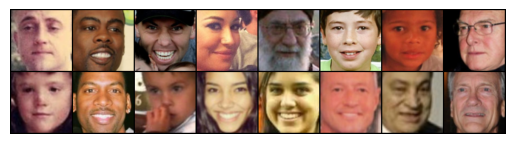

[1 1 1 1 0 1 0 0]


In [8]:
#only for visualize data in dataloader, it won't matters if you delete this block.
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [9]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #self.cnn1 = models.resnet50(pretrained=True)#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.fc1 = nn.Linear(2*32*100*100, 500)
        #self.fc1 = nn.Linear(2*1000, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)


    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [ ]:
NUMBER_EPOCHS=1

In [11]:
net = SiameseNetwork().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

best_epoch_accuracy = 0


for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        
        
        print(f'labels    {labels}      \n \n  img0  {img0}')
        
        
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    #-----------------
    acc = 100 * correct_val / total_val  
    
    if epoch == 0:
        best_epoch_accuracy = acc
        print('Model Saved0')
        torch.save(net.state_dict(), '/teamspace/studios/this_studio/ProjectIII/siamese_network/models/saved_model.pth')
    else:
        if best_epoch_accuracy < acc:
            best_epoch_accuracy = acc
            print('Model Saved1')
            torch.save(net.state_dict(), '/teamspace/studios/this_studio/ProjectIII/siamese_network/models/saved_model.pth')

        elif best_epoch_accuracy > acc:
            pass

        else:   #  best_epoch_accuracy == acc:
            pass
            
    #----------------------


    print('Accuracy of the network on the', total_val, 'val pairs in',val_famillies, ': %d %%' % (acc))
    #show_plot(counter,loss_history)
    


#torch.save(net.state_dict(), '/teamspace/studios/this_studio/ProjectIII/siamese_network/models')

Epoch： 0  start.
labels    tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0])      
   img0  tensor([[[[0.2667, 0.2157, 0.2157,  ..., 0.2824, 0.2510, 0.2353],
          [0.2510, 0.2000, 0.2078,  ..., 0.2863, 0.2549, 0.2392],
          [0.2392, 0.1922, 0.2000,  ..., 0.2902, 0.2588, 0.2431],
          ...,
          [0.1569, 0.1647, 0.1765,  ..., 0.4549, 0.4824, 0.4863],
          [0.1412, 0.1490, 0.1529,  ..., 0.4667, 0.4902, 0.4941],
          [0.1255, 0.1294, 0.1333,  ..., 0.4745, 0.4941, 0.4980]],

         [[0.2157, 0.1569, 0.1569,  ..., 0.1961, 0.1804, 0.1686],
          [0.2000, 0.1451, 0.1490,  ..., 0.2000, 0.1843, 0.1725],
          [0.1882, 0.1373, 0.1412,  ..., 0.2039, 0.1882, 0.1765],
          ...,
          [0.1176, 0.1294, 0.1451,  ..., 0.4235, 0.4549, 0.4627],
          [0.1020, 0.1098, 0.1216,  ..., 0.4392, 

KeyboardInterrupt: 

In [14]:
#torch.save(net.state_dict(), '/teamspace/studios/this_studio/ProjectIII/siamese_network/models/saved_model.pth')

In [16]:
#Later to restore:
model=SiameseNetwork()
model.load_state_dict(torch.load('/teamspace/studios/this_studio/ProjectIII/siamese_network/models/saved_model.pth'))
model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=640000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=2, bias=True)

In [23]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv
    
    def __init__(self,transform=None):
        self.test_df = pd.read_csv('/teamspace/studios/this_studio/ProjectIII/siamese_network/sample_submission.csv')#pandas用来读取csv文件
        self.transform = transform
        
    def __getitem__(self,index):
        #data in submission.csv:
        #       img_pair               is_related
        #face05508.jpg-face01210.jpg       0
        #face05820.jpg-face03938.jpg       0
        
        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]
        #print(img0_path,'-',img1_path) #reserved to check whether test data is in order.
        
        img0 = Image.open('/teamspace/studios/this_studio/ProjectIII/siamese_network/test/'+img0_path)
        img1 = Image.open('/teamspace/studios/this_studio/ProjectIII/siamese_network/test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1
    
    def __len__(self):
        return len(self.test_df)

In [18]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

In [20]:
test_df = pd.read_csv('/teamspace/studios/this_studio/ProjectIII/siamese_network/sample_submission.csv')#pandas用来读取csv文件
predictions=[]
with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = net(img0,img1)
        print(f'output: {outputs}')
        

        x, predicted = torch.max(outputs, 1)
        print(f'x:  {x}       predicted: {predicted}')
        
        
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)#taking care of here, the output data format is important for transfer
        
test_df['is_related'] = predictions
test_df.to_csv("submission.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

output: tensor([[-0.1643, -0.2345]], device='cuda:0')
x:  tensor([-0.1643], device='cuda:0')       predicted: tensor([0], device='cuda:0')
output: tensor([[-0.4060, -0.2642]], device='cuda:0')
x:  tensor([-0.2642], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.3207,  0.1073]], device='cuda:0')
x:  tensor([0.1073], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.3977,  0.0390]], device='cuda:0')
x:  tensor([0.0390], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.2374, -0.0061]], device='cuda:0')
x:  tensor([-0.0061], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.0978, -0.1809]], device='cuda:0')
x:  tensor([-0.0978], device='cuda:0')       predicted: tensor([0], device='cuda:0')
output: tensor([[-0.3469, -0.1566]], device='cuda:0')
x:  tensor([-0.1566], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.2415, -0.

output: tensor([[-0.3340, -0.1450]], device='cuda:0')
x:  tensor([-0.1450], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.4325, -0.0472]], device='cuda:0')
x:  tensor([-0.0472], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.2436, -0.3018]], device='cuda:0')
x:  tensor([-0.2436], device='cuda:0')       predicted: tensor([0], device='cuda:0')
output: tensor([[-0.0992, -0.0843]], device='cuda:0')
x:  tensor([-0.0843], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.2660, -0.1199]], device='cuda:0')
x:  tensor([-0.1199], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.3659, -0.2031]], device='cuda:0')
x:  tensor([-0.2031], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[-0.3621, -0.0766]], device='cuda:0')
x:  tensor([-0.0766], device='cuda:0')       predicted: tensor([1], device='cuda:0')
output: tensor([[ 0.1610, -

img_pair  is_related
0   face05508.jpg-face01210.jpg         0.0
1   face05750.jpg-face00898.jpg         1.0
2   face05820.jpg-face03938.jpg         1.0
3   face02104.jpg-face01172.jpg         1.0
4   face02428.jpg-face05611.jpg         1.0
5   face01219.jpg-face00274.jpg         0.0
6   face04262.jpg-face00555.jpg         1.0
7   face03697.jpg-face01892.jpg         1.0
8   face03524.jpg-face00319.jpg         1.0
9   face03410.jpg-face05368.jpg         1.0
10  face00292.jpg-face06004.jpg         0.0
11  face00353.jpg-face01203.jpg         0.0
12  face03140.jpg-face05223.jpg         1.0
13  face02915.jpg-face03312.jpg         0.0
14  face03012.jpg-face04103.jpg         0.0
15  face02240.jpg-face02336.jpg         1.0
16  face02131.jpg-face05209.jpg         1.0
17  face04105.jpg-face01209.jpg         0.0
18  face03565.jpg-face02509.jpg         0.0
19  face02836.jpg-face01540.jpg         0.0
20  face02832.jpg-face05386.jpg         1.0
21  face02596.jpg-face02913.jpg         1.0
22  face02231.jpg-face05835.jpg         1.0
23  face00451.jpg-face03664.jpg         0.0
24  face01644.jpg-face01682.jpg         1.0
25  face03988.jpg-face03379.jpg         1.0
26  face00908.jpg-face05944.jpg         1.0
27  face05117.jpg-face03498.jpg         1.0
28  face05466.jpg-face02942.jpg         0.0
29  face01537.jpg-face00187.jpg         0.0
30  face03609.jpg-face05219.jpg         0.0
31  face04820.jpg-face04526.jpg         0.0
32  face05963.jpg-face00176.jpg         1.0
33  face04372.jpg-face03101.jpg         0.0
34  face01496.jpg-face04980.jpg         1.0
35  face04215.jpg-face01123.jpg         1.0
36  face02624.jpg-face05000.jpg         1.0
37  face04434.jpg-face03376.jpg         1.0
38  face03417.jpg-face03461.jpg         0.0
39  face03142.jpg-face00593.jpg         1.0
40  face00094.jpg-face04094.jpg         1.0
41  face05700.jpg-face03910.jpg         1.0
42  face03620.jpg-face03203.jpg         1.0
43  face05074.jpg-face03806.jpg         1.0
44  face03836.jpg-face05917.jpg         1.0
45  face04495.jpg-face02846.jpg         0.0
46  face01690.jpg-face01033.jpg         1.0
47  face01766.jpg-face06057.jpg         0.0
48  face04896.jpg-face01845.jpg         1.0
49  face05468.jpg-face04688.jpg         1.0